In [2]:
import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, CatBoostRegressor

from Dataset_Construction import Balance_Ratio 
from Sampling import label_divide
from AdaClassifier import train_set, multiple_set, print_badC, bad_plot, line_chart, cf_matrix
from AdaRegressor import AUC, PR_curve, multiple_curve, PR_matrix, best_threshold 
from Aging_Score import score1

os.chdir('C:/Users/Darui Yen/OneDrive/桌面/data_after_mid') 
os.getcwd()

'C:\\Users\\Darui Yen\\OneDrive\\桌面\\data_after_mid'

### Boosting model

In [12]:
def CatBoostC(train_x, test_x, train_y, test_y, iter = 50, depth = 2, LR = 0.5, loss = 'Logloss'):
    
    clf = CatBoostClassifier(iterations = iter, depth = depth, learning_rate = LR, loss_function = loss, verbose = 0)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result


def CatBoostR(train_x, test_x, train_y, test_y, iter = 50, depth = 2, LR = 0.5, loss = 'RMSE'):
    
    reg = CatBoostRegressor(iterations = iter, depth = depth, learning_rate = LR, loss_function = loss, verbose = 0)
    reg.fit(train_x, train_y)
    predict_y = reg.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})

    return result

### Run all dataset

In [13]:
def runall_CatBoostC(num_set, trainset_x, test_x, trainset_y, test_y, record_bad = True):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        result = CatBoostC(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y)
        table = cf_matrix(result, trainset_y[f'set{i}'])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})
        
        if record_bad:
            bad_table = print_badC(result, test_x, Bad_Types) 
            bad_set = pd.concat([bad_set, bad_table]).rename(index = {0: f'dataset {i}'})

    if record_bad:
        return table_set, bad_set
    else:
        return table_set
    
    
def runall_CatBoostR(num_set, trainset_x, test_x, trainset_y, test_y, thres_target = 'Recall', threshold = 0.8, 
                          record_bad = True):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}

    for i in range(num_set):
        print('\n', f'Dataset {i}:')

        predict = CatBoostR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})
        
        if record_bad:
            bad_table = print_badC(predict, test_x, Bad_Types, threshold = best_thres)
            bad_set = pd.concat([bad_set, bad_table]).rename(index = {0: f'dataset {i}'})
    
    if record_bad:
        return pr_dict, table_set, bad_set
    else:
        return pr_dict, table_set

## Data Processing

In [3]:
###bad types###
bad = pd.read_csv('original_data/Bad_Types.csv').iloc[:, 1:]
Bad_Types = {bad.cb[i]:i for i in range (len(bad))}
print('Total bad types:', len(bad))

###single dataset###
test = pd.read_csv('original_data/TestingSet_0.csv').iloc[:, 2:]
train = pd.read_csv('original_data/TrainingSet_new.csv').iloc[:, 2:]
print('\ntraining data:', train.shape, '\nBalance Ratio:', Balance_Ratio(train))
print('\ntesting data:', test.shape, '\nBalance Ratio:', Balance_Ratio(test))

train_x, train_y, test_x, test_y = label_divide(train, test, 'GB')

###multiple dataset###
data_dict = multiple_set(num_set = 9)
trainset_x, trainset_y = train_set(data_dict, num_set = 9, label = 'GB')
test_x, test_y = label_divide(test, None, 'GB', train_only = True)

Total bad types: 62

training data: (77138, 83) 
Balance Ratio: 18.17902

testing data: (55903, 83) 
Balance Ratio: 3104.72222
Dimension of dataset 0 : (77138, 83)  balance ratio: 18.17902
Dimension of dataset 1 : (111685, 83)  balance ratio: 1.89572
Dimension of dataset 2 : (111685, 83)  balance ratio: 1.89572
Dimension of dataset 3 : (111685, 83)  balance ratio: 1.89572
Dimension of dataset 4 : (109674, 83)  balance ratio: 2.0
Dimension of dataset 5 : (32176, 83)  balance ratio: 1.66667
Dimension of dataset 6 : (32176, 83)  balance ratio: 1.66667
Dimension of dataset 7 : (32176, 83)  balance ratio: 1.66667
Dimension of dataset 8 : (30165, 83)  balance ratio: 2.0

 9 datasets are loaded.

Labels of  9 datasets are divided.



 Dataset 0:


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.008586301271845877
Types of Bad found: []
Types of Bad not found: [2, 2, 4, 5, 6, 7, 11, 15, 17, 22, 23, 33, 39, 40, 42, 45, 48, 49]

 Dataset 1:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.053431837289590896
Types of Bad found: []
Types of Bad not found: [2, 2, 4, 5, 6, 7, 11, 15, 17, 22, 23, 33, 39, 40, 42, 45, 48, 49]

 Dataset 2:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.06414682575174857
Types of Bad found: []
Types of Bad not found: [2, 2, 4, 5, 6, 7, 11, 15, 17, 22, 23, 33, 39, 40, 42, 45, 48, 49]

 Dataset 3:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.002397009105056974
Types of Bad found: []
Types of Bad not found: [2, 2, 4, 5, 6, 7, 11, 15, 17, 22, 23, 33, 39, 40, 42, 45, 48, 49]

 Dataset 4:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.05112426882278232
Types of Bad found: []
Types of Bad not found: [2, 2, 4, 5, 6, 7, 11, 15, 17, 22, 23, 33, 39, 40, 42, 45, 48, 49]

 Dataset 5:
Precision: 0.00028669724770642203 
Recall: 0.388888888888

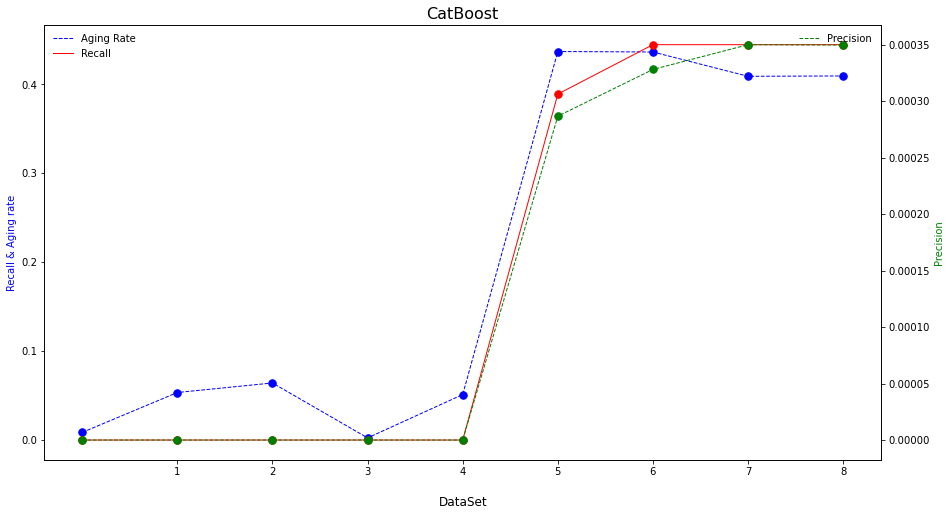

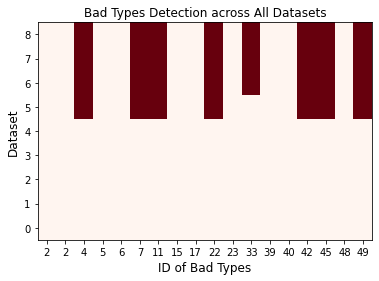


Run Time：21.893033 seconds


In [10]:
start = time.time()

table_set1, bad_set1 = runall_CatBoostC(9, trainset_x, test_x, trainset_y, test_y)
line_chart(table_set1, title = 'CatBoost')
bad_plot(bad_set1)

end = time.time()
print("\nRun Time：%f seconds" % (end - start))

In [14]:
table_set1

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,18.179015,73116.0,4022.0,0.0,480.0,18.0,55405.0,0.000000,0.000000,0.008586,0.000000,0.000000
dataset 1,1.895719,73116.0,38569.0,0.0,2987.0,18.0,52898.0,0.000000,0.000000,0.053432,0.000000,0.000000
dataset 2,1.895719,73116.0,38569.0,0.0,3586.0,18.0,52299.0,0.000000,0.000000,0.064147,0.000000,0.000000
dataset 3,1.895719,73116.0,38569.0,0.0,134.0,18.0,55751.0,0.000000,0.000000,0.002397,0.000000,0.000000
dataset 4,2.000000,73116.0,36558.0,0.0,2858.0,18.0,53027.0,0.000000,0.000000,0.051124,0.000000,0.000000
dataset 5,1.666667,20110.0,12066.0,7.0,24409.0,11.0,31476.0,0.000287,0.388889,0.436757,0.890402,0.000000
dataset 6,1.666667,20110.0,12066.0,8.0,24379.0,10.0,31506.0,0.000328,0.444444,0.436238,1.018812,0.312226
dataset 7,1.666667,20110.0,12066.0,8.0,22851.0,10.0,33034.0,0.000350,0.444444,0.408905,1.086914,0.326972
dataset 8,2.000000,20110.0,10055.0,8.0,22873.0,10.0,33012.0,0.000350,0.444444,0.409298,1.085869,0.326749



 Dataset 0:
Best Threshold: -0.08750825457720576 

Recall: [0.83333333] ,   Precision: [0.00027532] ,   Aging Rate: [0.97459886]
Types of Bad found: [2, 2, 7, 11, 15, 17, 22, 23, 33, 39, 40, 42, 45, 48, 49]
Types of Bad not found: [4, 5, 6]

 Dataset 1:
Best Threshold: -0.11774744423411276 

Recall: [0.83333333] ,   Precision: [0.000302] ,   Aging Rate: [0.88848541]
Types of Bad found: [2, 2, 4, 7, 11, 17, 22, 23, 33, 39, 40, 42, 45, 48, 49]
Types of Bad not found: [5, 6, 15]

 Dataset 2:
Best Threshold: -0.02721452161809773 

Recall: [0.83333333] ,   Precision: [0.00034086] ,   Aging Rate: [0.78718495]
Types of Bad found: [2, 2, 5, 7, 11, 15, 17, 22, 23, 33, 40, 42, 45, 48, 49]
Types of Bad not found: [4, 6, 39]

 Dataset 3:
Best Threshold: -0.01888930900364577 

Recall: [0.83333333] ,   Precision: [0.00029134] ,   Aging Rate: [0.92098814]
Types of Bad found: [2, 2, 4, 5, 7, 11, 17, 22, 23, 33, 39, 42, 45, 48, 49]
Types of Bad not found: [6, 15, 40]

 Dataset 4:
Best Threshold: -0.05

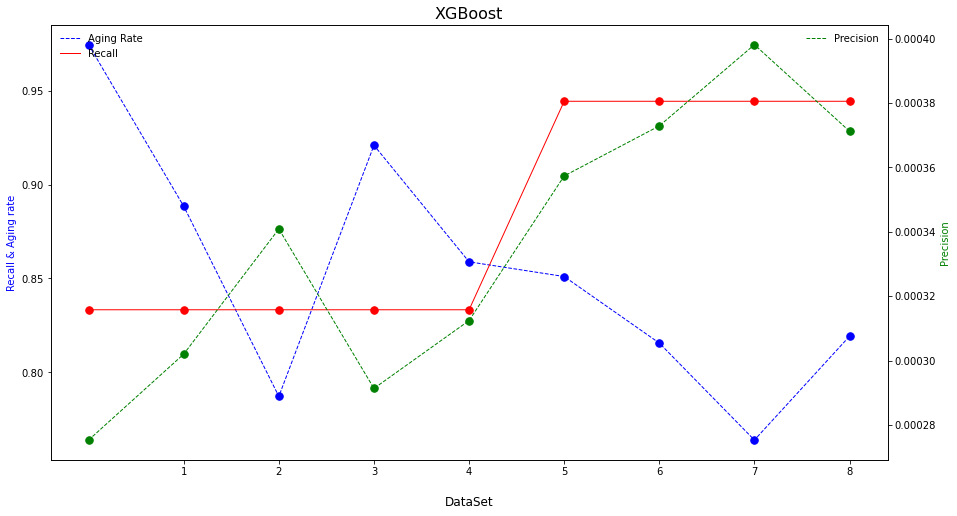

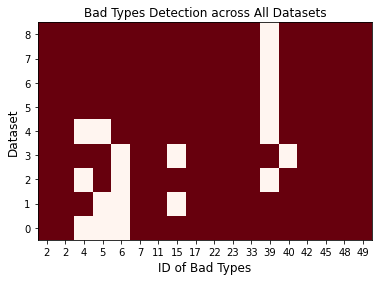


Run Time：7.084342 seconds


In [15]:
start = time.time()

pr_dict, table_set2, bad_set2 = runall_CatBoostR(9, trainset_x, test_x, trainset_y, test_y, thres_target = 'Recall', 
                                                threshold = 0.8)
line_chart(table_set2, title = 'XGBoost')
bad_plot(bad_set2)

end = time.time()
print("\nRun Time：%f seconds" % (end - start))

,Class_Prob,train_OK,train_NG,Balance Ratio,TP,FP,FN,TN,Recall,Precision,Aging Rate,Efficiency,Score
dataset 0,-0.087508,73116.0,4022.0,18.179015,15.0,54468.0,3.0,1417.0,0.833333,0.000275,0.974599,0.855053,0.000000
dataset 1,-0.117747,73116.0,38569.0,1.895719,15.0,49654.0,3.0,6231.0,0.833333,0.000302,0.888485,0.937926,0.000000
dataset 2,-0.027215,73116.0,38569.0,1.895719,15.0,43991.0,3.0,11894.0,0.833333,0.000341,0.787185,1.058625,0.601698
dataset 3,-0.018889,73116.0,38569.0,1.895719,15.0,51471.0,3.0,4414.0,0.833333,0.000291,0.920988,0.904825,0.000000
dataset 4,-0.051513,73116.0,36558.0,2.000000,15.0,47999.0,3.0,7886.0,0.833333,0.000312,0.858881,0.970255,0.000000
dataset 5,0.135845,20110.0,12066.0,1.666667,17.0,47559.0,1.0,8326.0,0.944444,0.000357,0.851046,1.109746,0.705092
dataset 6,0.194852,20110.0,12066.0,1.666667,17.0,45577.0,1.0,10308.0,0.944444,0.000373,0.815591,1.157987,0.726444
dataset 7,0.155719,20110.0,12066.0,1.666667,17.0,42688.0,1.0,13197.0,0.944444,0.000398,0.763912,1.236325,0.760121
dataset 8,0.169863,20110.0,10055.0,2.000000,17.0,45780.0,1.0,10105.0,0.944444,0.000371,0.819223,1.152855,0.724195


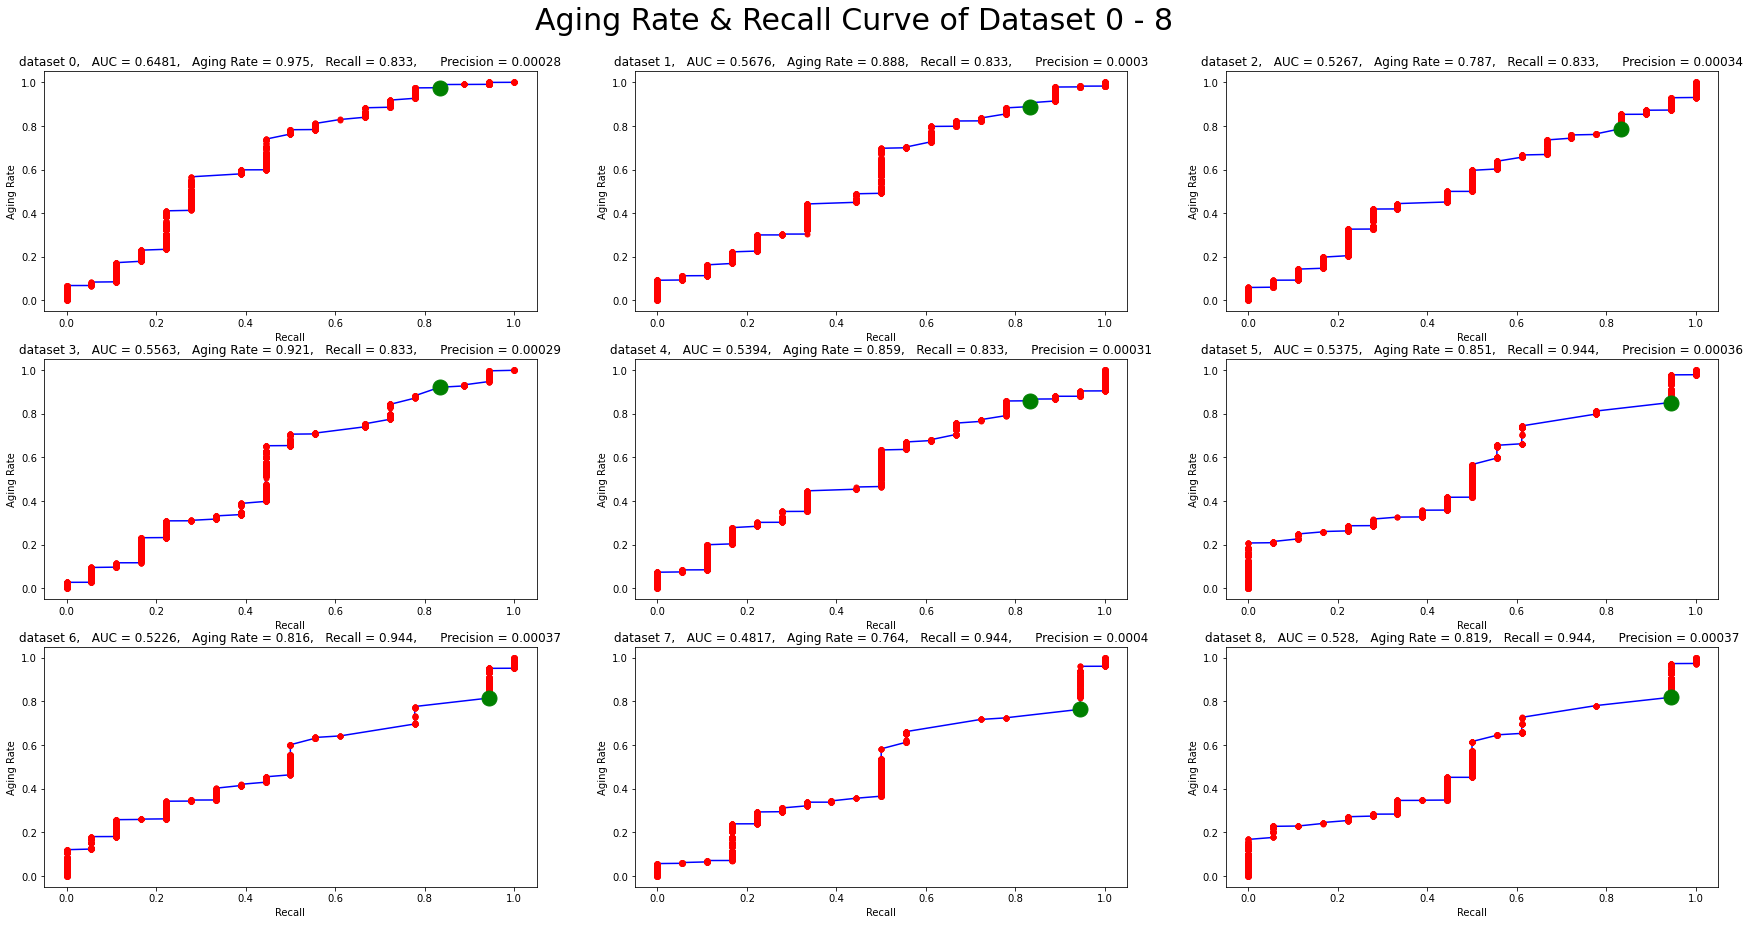

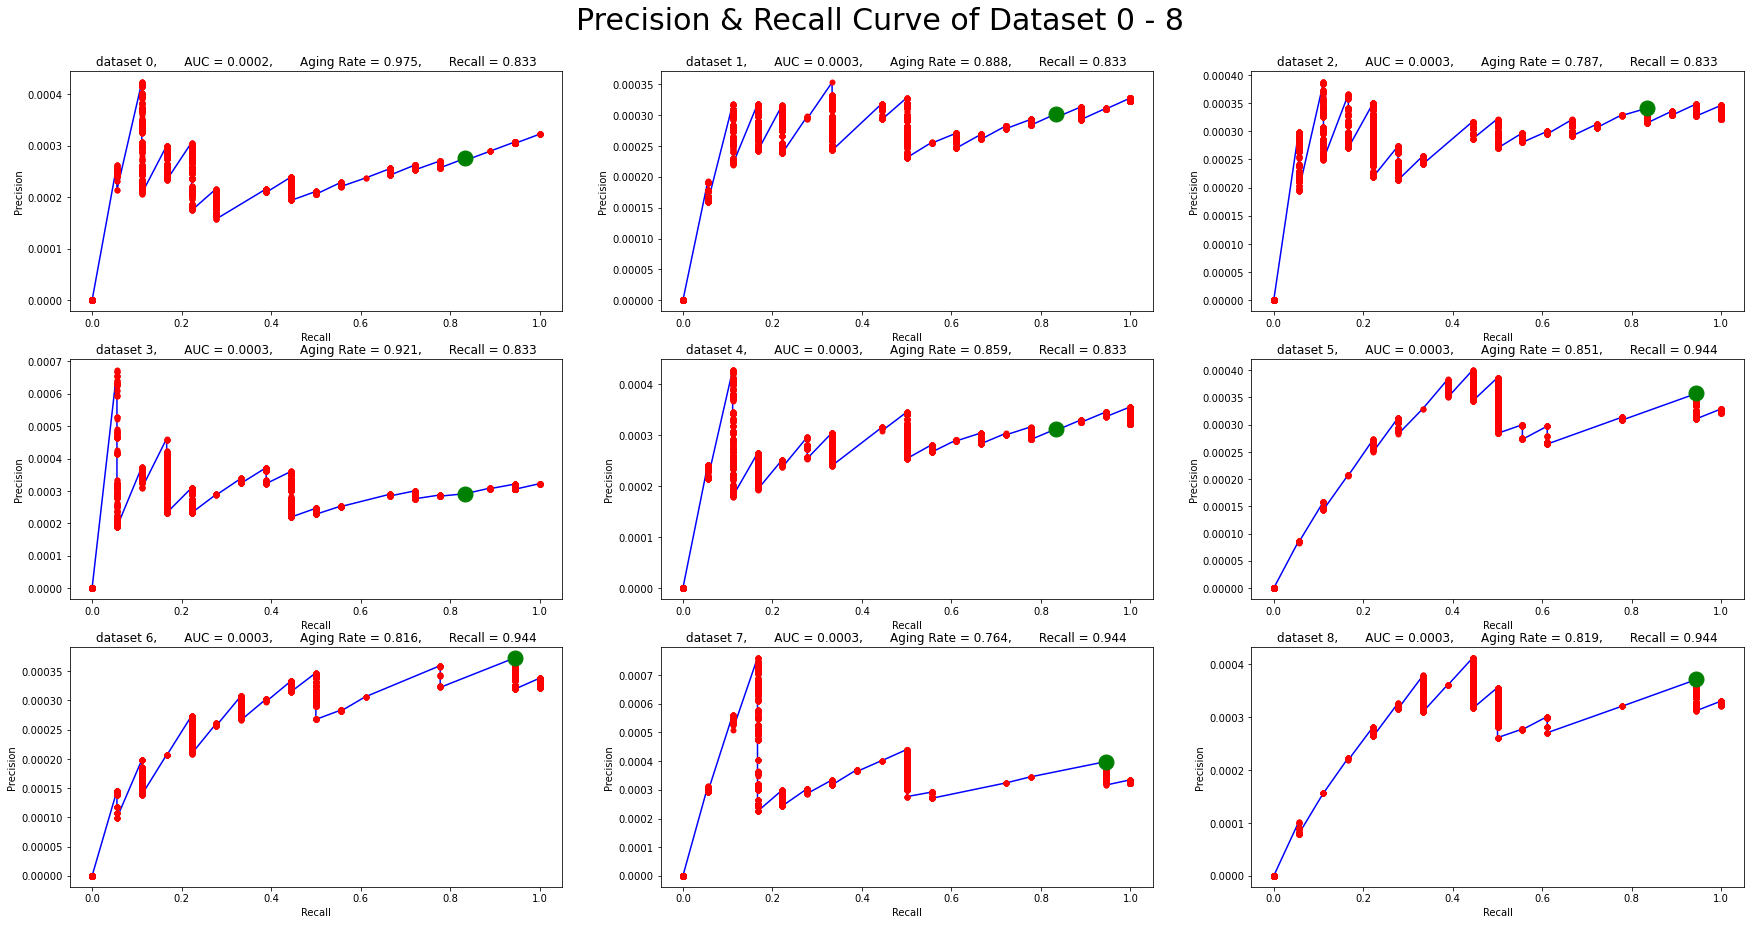

In [16]:
multiple_curve(3, 3, pr_dict, table_set2, target = 'Aging Rate')
multiple_curve(3, 3, pr_dict, table_set2, target = 'Precision')
table_set2